In [2]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [ ]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch

# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

In [6]:
from platform import python_version
import sklearn
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.4
pandas==0.25.1
numpy==1.16.5
sklearn==0.21.3
torch==1.3.1
matplotlib==3.1.1


# Long Short-Term Memory

In [8]:
# Import additional libs
import warnings
import itertools
import statsmodels.api as sm

### Load Data

In [9]:
# Load the data
df = pd.read_csv('avocado.csv')
cols = df.columns

#### Select Timeseries

In [10]:
region = 'Albany'
Type = 'conventional'

In [15]:
df_sub = df.loc[ (df.region == region) & (df.type == Type)]

# keep only price and dates
keepcols = ['Date', 'AveragePrice', 'Volume']
ts = df_sub[keepcols]

In [16]:
ts = ts.sort_values('Date')
ts

,Date,AveragePrice
51,2015-01-04,1.22
50,2015-01-11,1.24
49,2015-01-18,1.17
48,2015-01-25,1.06
47,2015-02-01,0.99
...,...,...
8482,2018-02-25,1.28
8481,2018-03-04,1.08
8480,2018-03-11,1.12
8479,2018-03-18,1.35


In [17]:
ts.index = ts.Date
ts = ts.drop(['Date'], axis=1)
ts

,AveragePrice
Date,
2015-01-04,1.22
2015-01-11,1.24
2015-01-18,1.17
2015-01-25,1.06
2015-02-01,0.99
...,...
2018-02-25,1.28
2018-03-04,1.08
2018-03-11,1.12


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


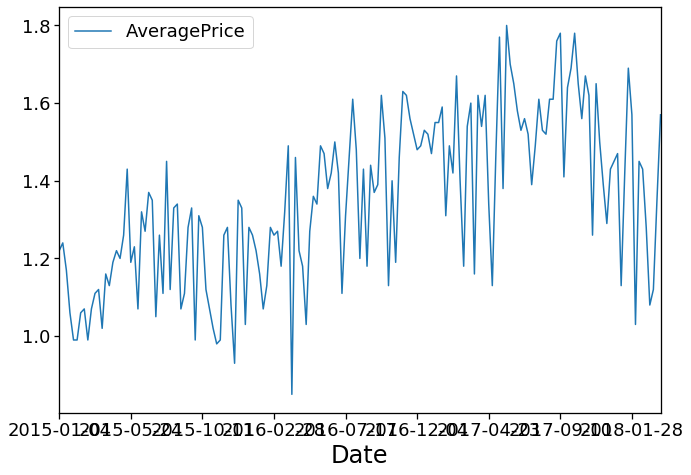

In [18]:
ts.plot()

### Train test split

In [20]:
test_data_size = 13

train_data = ts[:-test_data_size]
test_data = ts[-test_data_size:]

### Scale data

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

### Create sequences

In [25]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [26]:
train_window = 12

In [27]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [28]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [29]:
train_inout_seq

[(tensor([-0.2211, -0.1789, -0.3263, -0.5579, -0.7053, -0.7053, -0.5579, -0.5368,
          -0.7053, -0.5368, -0.4526, -0.4316]), tensor([-0.6421])),
 (tensor([-0.1789, -0.3263, -0.5579, -0.7053, -0.7053, -0.5579, -0.5368, -0.7053,
          -0.5368, -0.4526, -0.4316, -0.6421]),
  tensor([-0.3474])),
 (tensor([-0.3263, -0.5579, -0.7053, -0.7053, -0.5579, -0.5368, -0.7053, -0.5368,
          -0.4526, -0.4316, -0.6421, -0.3474]), tensor([-0.4105])),
 (tensor([-0.5579, -0.7053, -0.7053, -0.5579, -0.5368, -0.7053, -0.5368, -0.4526,
          -0.4316, -0.6421, -0.3474, -0.4105]), tensor([-0.2842])),
 (tensor([-0.7053, -0.7053, -0.5579, -0.5368, -0.7053, -0.5368, -0.4526, -0.4316,
          -0.6421, -0.3474, -0.4105, -0.2842]), tensor([-0.2211])),
 (tensor([-0.7053, -0.5579, -0.5368, -0.7053, -0.5368, -0.4526, -0.4316, -0.6421,
          -0.3474, -0.4105, -0.2842, -0.2211]), tensor([-0.2632])),
 (tensor([-0.5579, -0.5368, -0.7053, -0.5368, -0.4526, -0.4316, -0.6421, -0.3474,
          -0.410

### Model

In [31]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [32]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


### Training the model

In [34]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00353256
epoch:  26 loss: 0.02193405
epoch:  51 loss: 0.09190983
epoch:  76 loss: 0.00036794
epoch: 101 loss: 0.00271940
epoch: 126 loss: 0.00064338
epoch: 149 loss: 0.0002533889


### Making predictions

In [35]:
fut_pred = 13

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.9578947424888611, 0.6842105388641357, 0.49473685026168823, 0.7263157963752747, 0.621052622795105, -0.13684210181236267, 0.6842105388641357, 0.3684210479259491, 0.13684210181236267, -0.0736842080950737, 0.2210526317358017, 0.2631579041481018]


In [36]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [39]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

x = np.arange(156, 169, 1)

[[1.409452  ]
 [1.49411092]
 [1.54291347]
 [1.45425892]
 [1.61908797]
 [1.55172856]
 [1.60081986]
 [1.34846258]
 [1.32348483]
 [1.46092864]
 [1.66133975]
 [1.52657887]
 [1.73337051]]


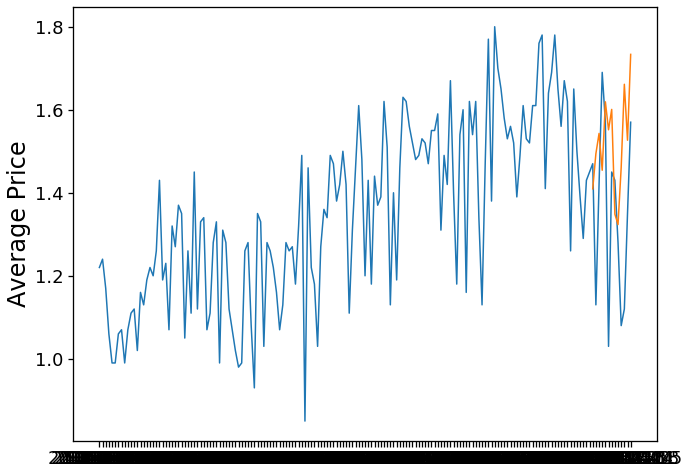

In [43]:
plt.ylabel('Average Price')
#plt.autoscale(axis='x', tight=True)
plt.plot(ts.AveragePrice)
plt.plot(x,actual_predictions)
plt.show()